In [ ]:
from syngenerator import *
import numpy as np
import matplotlib
# matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt

train_gen = SynGeneratorParser.load('org_datasets/syn_org_data/0_1_train.json')
test_gen = SynGeneratorParser.load('org_datasets/syn_org_data/0_1_test.json')

X_train, y_train = train_gen.generate(seed=0)
X_test, y_test = test_gen.generate(seed=1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


100%|██████████| 600/600 [00:00<00:00, 3434.50it/s]

(array([0., 1.]), array([487, 513], dtype=int64))
(array([0., 1.]), array([300, 300], dtype=int64))


In [96]:
from methods.methods import *
from utils import *
from metrics import *

m = Methods(verbose=False, gpu_accel=True)

methods = ['pca', 'dlmp-tsne', 'dlmp-umap']
# methods = m.available()


In [97]:
from tqdm import tqdm

for method_name in tqdm(methods):
    try:
        method = m.get(method_name)
        method.fit(X_train)
        p_train = method.transform(X_train)
        p_test = method.transform_oos(X_test)

    except:
        print(f"Method '{method_name}' failed")
        p_train = np.zeros((0,2))
        p_test = np.zeros((0,2))
    
    save_projection(f"org_datasets/syn_org_data/{method_name}_train.csv", p_train)
    save_projection(f"org_datasets/syn_org_data/{method_name}_test.csv", p_test)


  0%|          | 0/3 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 40.
Epoch 50: early stopping


 67%|██████▋   | 2/3 [00:04<00:02,  2.20s/it]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping


100%|██████████| 3/3 [00:09<00:00,  3.12s/it]


In [98]:
import pandas as pd

metrics = Metrics()

metrics_name = metrics.available()

metdf = pd.DataFrame(columns=metrics_name, index=methods)

for method_name in methods:
    p_train = load_projection(f"org_datasets/syn_org_data/{method_name}_train.csv")
    p_test = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")
    metrics.update_metrics(X_train, p_train, X_test, p_test, y_train, y_test)

    for metric_idx, metric_name in enumerate(metrics_name):
        result, full_name = metrics.run_single(metric_name)
        metdf.loc[method_name, metric_name] = result

print(metdf)

                  t         c        nh        lc        sd        tp  \
pca        0.738252  0.863295  0.774524   0.20381   0.56917 -0.103534   
dlmp-tsne  0.718683  0.827063  0.837619     0.205  0.362169 -0.127948   
dlmp-umap  0.748085  0.835787  0.882857  0.220238  0.373253 -0.126399   

                 sc       dsc   acc_oos  acc_e  
pca        0.148647  0.676667  0.756667  0.724  
dlmp-tsne  0.266928      0.84  0.793333  0.918  
dlmp-umap  0.308848  0.888333  0.856667  0.901  


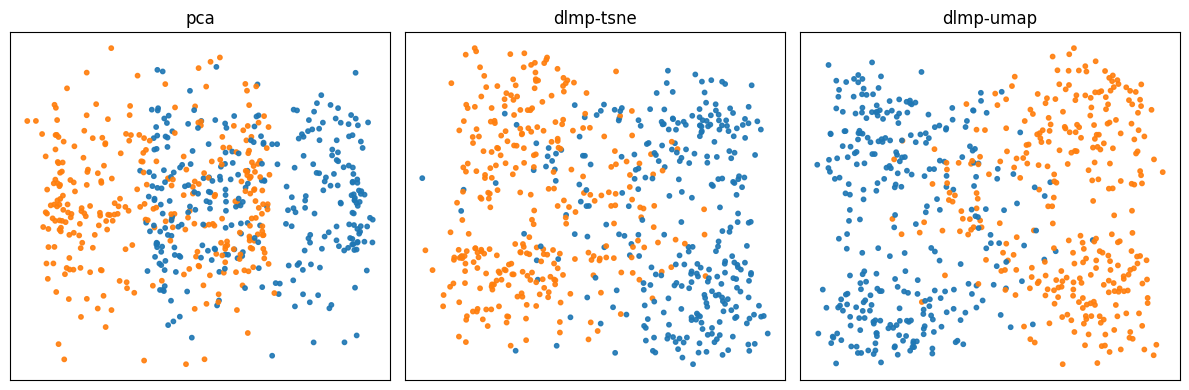

In [ ]:
from matplotlib.pyplot import Normalize

ncols = min(4, len(methods))
nrows = int(np.ceil(len(methods) / ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

for i, method_name in enumerate(methods):

    r = i // ncols
    c = i % ncols
    p = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")
    
    axes = ax[r, c] if nrows > 1 else ax[i] if ncols > 1 else ax

    axes.scatter(p[:,0], p[:,1], c=y_test, cmap='tab10', marker='o', s=10, alpha=0.9, norm=Normalize(vmin=0, vmax=9))

    axes.set_title(methods[i])
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


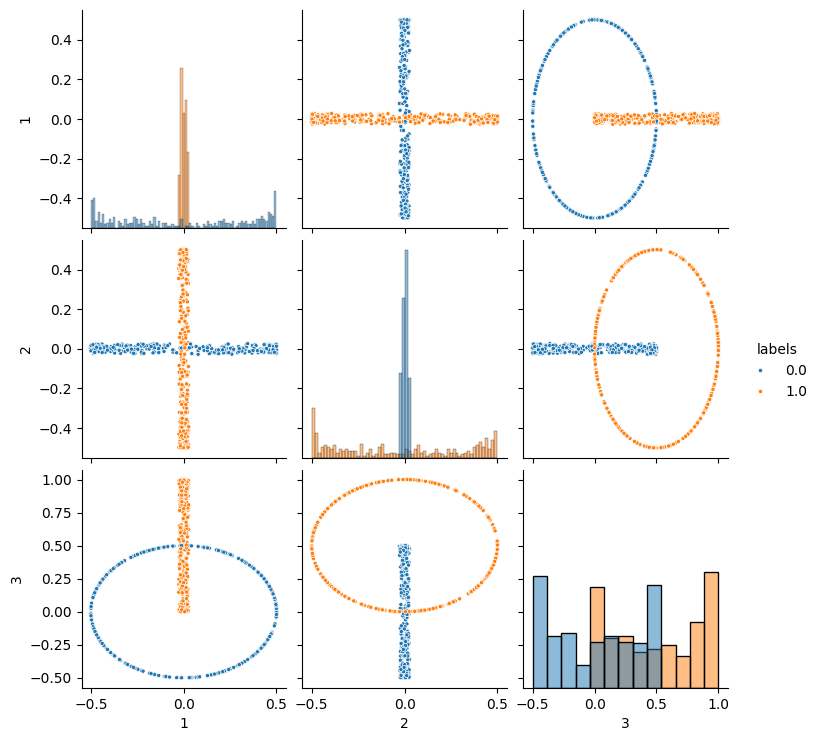

In [100]:
# 根据dataset的维度，绘制散点图矩阵
import seaborn as sns
import pandas as pd

subdata = X_test[:, :3]

df = pd.DataFrame(subdata, columns=[str(i+1) for i in range(subdata.shape[1])])
df['labels'] = y_test

sns.pairplot(df, diag_kind="hist", markers='.', hue='labels', palette='tab10')
plt.show()


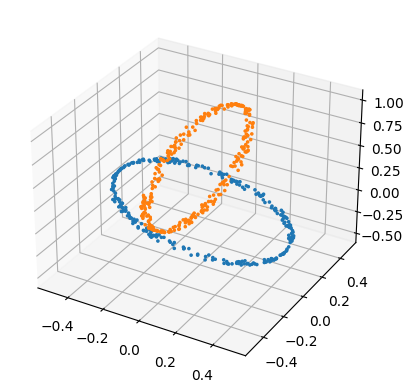

In [101]:
# 绘制三维散点图

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selected_axis = [0,1,2]

ax.scatter(X_test[:, selected_axis[0]], X_test[:, selected_axis[1]], X_test[:, selected_axis[2]], 
           c=y_test, norm=Normalize(vmin=0, vmax=9), cmap='tab10', marker='.', s=10 ,alpha=1.0)
plt.show()